## 📊 Resumen de Preparación de Datos (Data Preprocessing)



- En esta etapa, se ha transformado el dataset original en un conjunto de datos optimizado para modelos de Machine Learning. El proceso se dividió en cuatro pasos clave:
- 1. Selección y Tipado de Datos Se filtraron las variables de interés (product_category, price, total_revenue, rating) para reducir la dimensionalidad y el uso de memoria. 
- 2. Se aseguró que las categorías de producto fueran tratadas como cadenas de texto para su posterior procesamiento
- 3. Ingeniería de Características (Feature Engineering)Para convertir los datos crudos en información interpretable por un algoritmo, se aplicaron las siguientes técnicas:Label Encoding (Manual): Se generó un índice numérico (cat_index) para la categoría del producto mediante un ranking denso, permitiendo representar datos categóricos de forma numérica.
- 4. Transformación Logarítmica: Se aplicó $\log(1 + x)$ a total_revenue para reducir el sesgo (skewness) de los datos y manejar mejor los valores atípicos (outliers)
- .Estandarización (Z-score): Las variables price y rating fueron normalizadas restando la media y dividiendo por la desviación estándar:$$z = \frac{x - \mu}{\sigma}$$
- Esto garantiza que ambas variables estén en la misma escala, evitando que el modelo dé prioridad a una variable solo por tener valores numéricos más altos
- 5. Refinamiento del DatasetSe creó un nuevo DataFrame llamado df_Inte que contiene exclusivamente las variables procesadas y listas para el modelado:cat_indexprice_scaledrating_scaledtotal_revenue_log4. Muestreo (Sampling)Para agilizar las iteraciones iniciales del modelo o realizar pruebas rápidas, se extrajo una muestra aleatoria de 300 registros utilizando una semilla fija (seed=42) para garantizar la reproducibilidad de los resultados.


In [2]:
# --- Procesamiento y Limpieza ---
import pandas as pd
import numpy as np
import polars as pl
import polars.selectors as cs
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge # La opción fácil

# --- Modelado Bayesiano ---
import pymc as pm
import arviz as az



# --- Visualización ---
import matplotlib.pyplot as plt
import seaborn as sns


# La ruta entra a la carpeta 'dataset' y luego busca el archivo
df = pl.read_csv("../dataset/amazon_sales_dataset.csv")
# Para mi modelo jerarquico necesito transformar la columna de categorias (hoga, electronica a int)

print(df)


shape: (50_000, 13)
┌──────────┬────────────┬────────────┬────────────┬───┬────────┬───────────┬───────────┬───────────┐
│ order_id ┆ order_date ┆ product_id ┆ product_ca ┆ … ┆ rating ┆ review_co ┆ discounte ┆ total_rev │
│ ---      ┆ ---        ┆ ---        ┆ tegory     ┆   ┆ ---    ┆ unt       ┆ d_price   ┆ enue      │
│ i64      ┆ str        ┆ i64        ┆ ---        ┆   ┆ f64    ┆ ---       ┆ ---       ┆ ---       │
│          ┆            ┆            ┆ str        ┆   ┆        ┆ i64       ┆ f64       ┆ f64       │
╞══════════╪════════════╪════════════╪════════════╪═══╪════════╪═══════════╪═══════════╪═══════════╡
│ 1        ┆ 2022-04-13 ┆ 2637       ┆ Books      ┆ … ┆ 3.5    ┆ 443       ┆ 115.88    ┆ 463.52    │
│ 2        ┆ 2023-03-12 ┆ 2300       ┆ Fashion    ┆ … ┆ 3.7    ┆ 475       ┆ 242.08    ┆ 1210.4    │
│ 3        ┆ 2022-09-28 ┆ 3670       ┆ Sports     ┆ … ┆ 4.4    ┆ 183       ┆ 396.64    ┆ 793.28    │
│ 4        ┆ 2022-04-17 ┆ 2522       ┆ Books      ┆ … ┆ 5.0    ┆ 212   

In [3]:
# Por que elijo estas columnas ? 

columnas_interesantes = [
    "product_category",
    "price",
    "total_revenue",
    "rating"
    
]  

# Creando dataframe de trabajo 
df_modelJ = df.select(columnas_interesantes)

print(df_modelJ)

shape: (50_000, 4)
┌──────────────────┬────────┬───────────────┬────────┐
│ product_category ┆ price  ┆ total_revenue ┆ rating │
│ ---              ┆ ---    ┆ ---           ┆ ---    │
│ str              ┆ f64    ┆ f64           ┆ f64    │
╞══════════════════╪════════╪═══════════════╪════════╡
│ Books            ┆ 128.75 ┆ 463.52        ┆ 3.5    │
│ Fashion          ┆ 302.6  ┆ 1210.4        ┆ 3.7    │
│ Sports           ┆ 495.8  ┆ 793.28        ┆ 4.4    │
│ Books            ┆ 371.95 ┆ 1264.64       ┆ 5.0    │
│ Beauty           ┆ 201.68 ┆ 806.72        ┆ 4.6    │
│ …                ┆ …      ┆ …             ┆ …      │
│ Beauty           ┆ 26.99  ┆ 134.95        ┆ 2.4    │
│ Beauty           ┆ 294.23 ┆ 1324.05       ┆ 3.1    │
│ Electronics      ┆ 352.11 ┆ 985.92        ┆ 3.1    │
│ Beauty           ┆ 307.54 ┆ 292.16        ┆ 1.8    │
│ Home & Kitchen   ┆ 253.44 ┆ 177.41        ┆ 2.1    │
└──────────────────┴────────┴───────────────┴────────┘


In [4]:
# Esto es lo más importante, para ver las escalas, minimos, maximos 
df_modelJ.describe()

statistic,product_category,price,total_revenue,rating
str,str,f64,f64,f64
"""count""","""50000""",50000.0,50000.0,50000.0
"""null_count""","""0""",0.0,0.0,0.0
"""mean""",null,252.50726,657.331475,2.996316
"""std""",null,143.025544,526.223968,1.154295
"""min""","""Beauty""",5.01,3.84,1.0
"""25%""",null,127.84,240.32,2.0
"""50%""",null,252.97,505.44,3.0
"""75%""",null,376.33,968.96,4.0
"""max""","""Sports""",499.99,2499.55,5.0


In [5]:

# 1. Forzamos la columna a String puro para 'desbloquearla'
df_modelJ = df_modelJ.with_columns(
    pl.col("product_category").cast(pl.String)
)

# 2. Creamos el índice numérico (0, 1, 2...)
df_modelJ = df_modelJ.with_columns(
    pl.col("product_category").rank("dense").alias("cat_index").cast(pl.Int64) - 1
)

# Para que verifiques qué número le tocó a cada una:
print(df_modelJ.select(["product_category", "cat_index"]).unique().sort("cat_index"))

shape: (6, 2)
┌──────────────────┬───────────┐
│ product_category ┆ cat_index │
│ ---              ┆ ---       │
│ str              ┆ i64       │
╞══════════════════╪═══════════╡
│ Beauty           ┆ 0         │
│ Books            ┆ 1         │
│ Electronics      ┆ 2         │
│ Fashion          ┆ 3         │
│ Home & Kitchen   ┆ 4         │
│ Sports           ┆ 5         │
└──────────────────┴───────────┘


In [6]:
# esta función es mágica, se toman los valores de la columna total_revenue para transformalos en números pequeños, detrás de está función hay formulas
# por ejemplo 1.000.000 a diferencia de 1.000 nos arrojaria números similares, por ejemplo 2.45 y 4.67, sin estos valores similares el modelo
# no entenderia, se sesgaria y confiaria más en 1.000.000 que en 
df_modelJ = df_modelJ.with_columns(
    total_revenue_log = pl.col("total_revenue").log1p()
    
)

# Ahora imprimimos las primeras 5 filas
print(df_modelJ.head(5))

shape: (5, 6)
┌──────────────────┬────────┬───────────────┬────────┬───────────┬───────────────────┐
│ product_category ┆ price  ┆ total_revenue ┆ rating ┆ cat_index ┆ total_revenue_log │
│ ---              ┆ ---    ┆ ---           ┆ ---    ┆ ---       ┆ ---               │
│ str              ┆ f64    ┆ f64           ┆ f64    ┆ i64       ┆ f64               │
╞══════════════════╪════════╪═══════════════╪════════╪═══════════╪═══════════════════╡
│ Books            ┆ 128.75 ┆ 463.52        ┆ 3.5    ┆ 1         ┆ 6.141005          │
│ Fashion          ┆ 302.6  ┆ 1210.4        ┆ 3.7    ┆ 3         ┆ 7.099532          │
│ Sports           ┆ 495.8  ┆ 793.28        ┆ 4.4    ┆ 5         ┆ 6.677436          │
│ Books            ┆ 371.95 ┆ 1264.64       ┆ 5.0    ┆ 1         ┆ 7.143333          │
│ Beauty           ┆ 201.68 ┆ 806.72        ┆ 4.6    ┆ 0         ┆ 6.694215          │
└──────────────────┴────────┴───────────────┴────────┴───────────┴───────────────────┘


In [7]:
df_modelJ = df_modelJ.with_columns([
    # Estandarizamos el precio (Z-score)
    ((pl.col("price") - pl.col("price").mean()) / pl.col("price").std()).alias("price_scaled"),
    
    # Estandarizamos las reseñas
     ((pl.col("rating") - pl.col("rating").mean()) / pl.col("rating").std()).alias("rating_scaled")
  
])

print(df_modelJ)

shape: (50_000, 8)
┌─────────────┬────────┬─────────────┬────────┬───────────┬─────────────┬─────────────┬────────────┐
│ product_cat ┆ price  ┆ total_reven ┆ rating ┆ cat_index ┆ total_reven ┆ price_scale ┆ rating_sca │
│ egory       ┆ ---    ┆ ue          ┆ ---    ┆ ---       ┆ ue_log      ┆ d           ┆ led        │
│ ---         ┆ f64    ┆ ---         ┆ f64    ┆ i64       ┆ ---         ┆ ---         ┆ ---        │
│ str         ┆        ┆ f64         ┆        ┆           ┆ f64         ┆ f64         ┆ f64        │
╞═════════════╪════════╪═════════════╪════════╪═══════════╪═════════════╪═════════════╪════════════╡
│ Books       ┆ 128.75 ┆ 463.52      ┆ 3.5    ┆ 1         ┆ 6.141005    ┆ -0.865281   ┆ 0.436356   │
│ Fashion     ┆ 302.6  ┆ 1210.4      ┆ 3.7    ┆ 3         ┆ 7.099532    ┆ 0.350236    ┆ 0.609622   │
│ Sports      ┆ 495.8  ┆ 793.28      ┆ 4.4    ┆ 5         ┆ 6.677436    ┆ 1.701044    ┆ 1.216053   │
│ Books       ┆ 371.95 ┆ 1264.64     ┆ 5.0    ┆ 1         ┆ 7.143333    

In [8]:
print(df_modelJ)

shape: (50_000, 8)
┌─────────────┬────────┬─────────────┬────────┬───────────┬─────────────┬─────────────┬────────────┐
│ product_cat ┆ price  ┆ total_reven ┆ rating ┆ cat_index ┆ total_reven ┆ price_scale ┆ rating_sca │
│ egory       ┆ ---    ┆ ue          ┆ ---    ┆ ---       ┆ ue_log      ┆ d           ┆ led        │
│ ---         ┆ f64    ┆ ---         ┆ f64    ┆ i64       ┆ ---         ┆ ---         ┆ ---        │
│ str         ┆        ┆ f64         ┆        ┆           ┆ f64         ┆ f64         ┆ f64        │
╞═════════════╪════════╪═════════════╪════════╪═══════════╪═════════════╪═════════════╪════════════╡
│ Books       ┆ 128.75 ┆ 463.52      ┆ 3.5    ┆ 1         ┆ 6.141005    ┆ -0.865281   ┆ 0.436356   │
│ Fashion     ┆ 302.6  ┆ 1210.4      ┆ 3.7    ┆ 3         ┆ 7.099532    ┆ 0.350236    ┆ 0.609622   │
│ Sports      ┆ 495.8  ┆ 793.28      ┆ 4.4    ┆ 5         ┆ 6.677436    ┆ 1.701044    ┆ 1.216053   │
│ Books       ┆ 371.95 ┆ 1264.64     ┆ 5.0    ┆ 1         ┆ 7.143333    

In [9]:
df_Modelps = [
    "cat_index",
    "price_scaled",
    "rating_scaled",
    "total_revenue_log"
]

df_Inte = df_modelJ.select(df_Modelps)

print(df_Inte)

shape: (50_000, 4)
┌───────────┬──────────────┬───────────────┬───────────────────┐
│ cat_index ┆ price_scaled ┆ rating_scaled ┆ total_revenue_log │
│ ---       ┆ ---          ┆ ---           ┆ ---               │
│ i64       ┆ f64          ┆ f64           ┆ f64               │
╞═══════════╪══════════════╪═══════════════╪═══════════════════╡
│ 1         ┆ -0.865281    ┆ 0.436356      ┆ 6.141005          │
│ 3         ┆ 0.350236     ┆ 0.609622      ┆ 7.099532          │
│ 5         ┆ 1.701044     ┆ 1.216053      ┆ 6.677436          │
│ 1         ┆ 0.835115     ┆ 1.735851      ┆ 7.143333          │
│ 0         ┆ -0.355372    ┆ 1.389319      ┆ 6.694215          │
│ …         ┆ …            ┆ …             ┆ …                 │
│ 0         ┆ -1.576762    ┆ -0.516606     ┆ 4.912287          │
│ 0         ┆ 0.291715     ┆ 0.089825      ┆ 7.189205          │
│ 2         ┆ 0.696398     ┆ 0.089825      ┆ 6.894589          │
│ 0         ┆ 0.384776     ┆ -1.036404     ┆ 5.680719          │
│ 4   

In [10]:
# Tomamos el 40% de forma aleatoria
df_sample = df_Inte.sample( n = 300, seed=42) 

print(f"Filas originales: {len(df_Inte)}")
print(f"Filas para el modelo: {len(df_sample)}")
print(df_sample)

Filas originales: 50000
Filas para el modelo: 300
shape: (300, 4)
┌───────────┬──────────────┬───────────────┬───────────────────┐
│ cat_index ┆ price_scaled ┆ rating_scaled ┆ total_revenue_log │
│ ---       ┆ ---          ┆ ---           ┆ ---               │
│ i64       ┆ f64          ┆ f64           ┆ f64               │
╞═══════════╪══════════════╪═══════════════╪═══════════════════╡
│ 4         ┆ 0.970615     ┆ -0.34334      ┆ 7.474205          │
│ 1         ┆ -1.173128    ┆ 0.089825      ┆ 4.916764          │
│ 2         ┆ 1.031583     ┆ -0.083441     ┆ 5.638461          │
│ 0         ┆ -0.691466    ┆ 1.562585      ┆ 4.989956          │
│ 3         ┆ 1.203161     ┆ 0.089825      ┆ 6.522593          │
│ …         ┆ …            ┆ …             ┆ …                 │
│ 1         ┆ 1.382919     ┆ 0.956154      ┆ 5.889543          │
│ 5         ┆ -1.596759    ┆ -0.34334      ┆ 3.224062          │
│ 1         ┆ 0.985577     ┆ -0.776505     ┆ 7.479638          │
│ 4         ┆ -0.044658 

Iniciando ajuste rápido (ADVI)...


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_a, sigma_a, a_cat, b_p, b_r, sigma]


Output()

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 2394 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


¡Listo! Generando gráficas...


array([<Axes: title={'center': 'b_p'}>, <Axes: title={'center': 'b_r'}>],
      dtype=object)

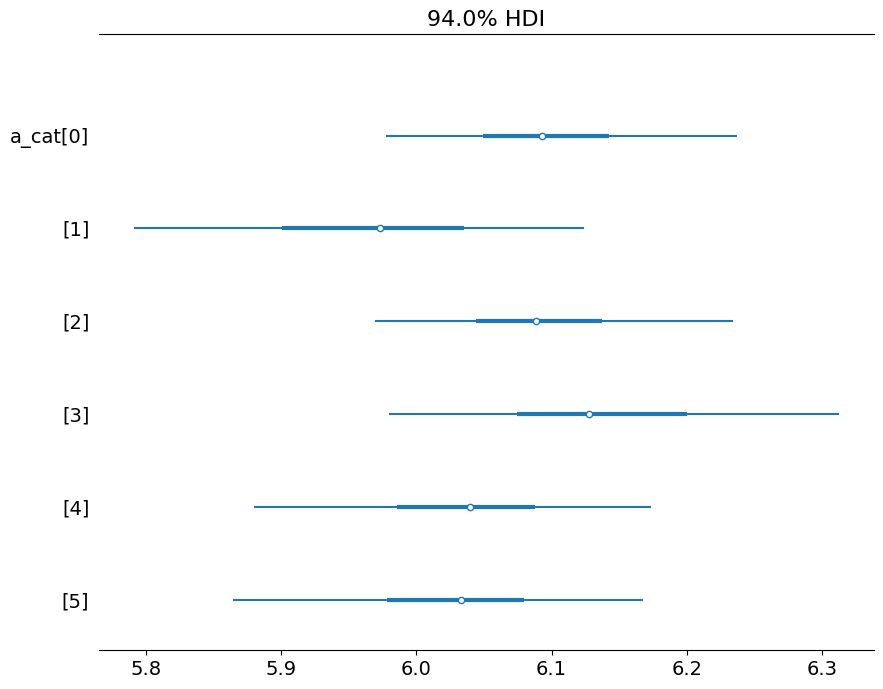

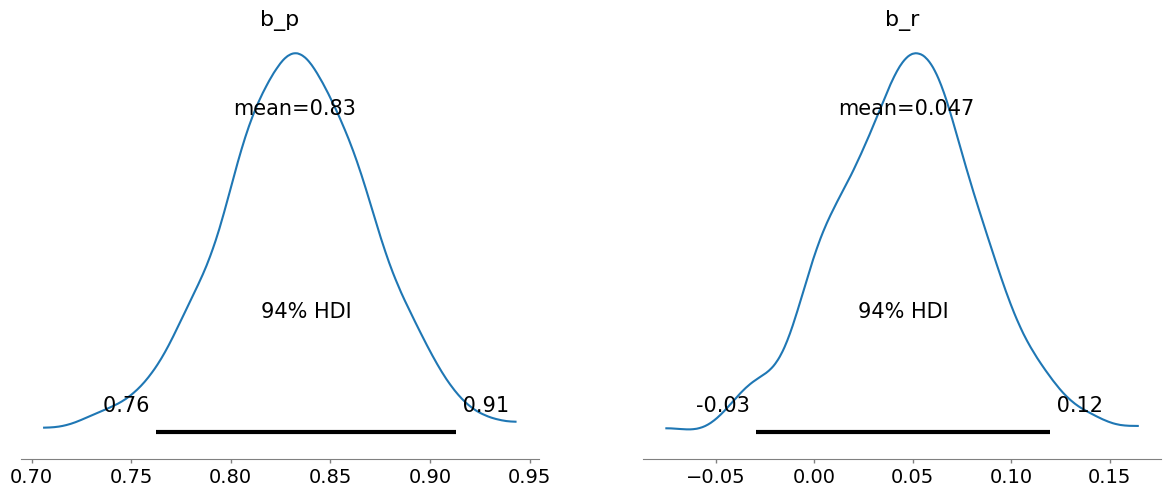

In [11]:
import pymc as pm
import numpy as np
import arviz as az


# 1. Aseguramos datos limpios de tu muestra
y_vals = np.array(df_sample["total_revenue_log"].to_list(), dtype=np.float64)
p_vals = np.array(df_sample["price_scaled"].to_list(), dtype=np.float64)
r_vals = np.array(df_sample["rating_scaled"].to_list(), dtype=np.float64)
cat_raw = df_sample["cat_index"].to_list()
cat_names, cat_idx = np.unique(cat_raw, return_inverse=True)

# --- EL MODELO ---
with pm.Model() as model_turbo:
    # Priors
    mu_a = pm.Normal("mu_a", 0, 1)
    sigma_a = pm.HalfNormal("sigma_a", 1)
    a_cat = pm.Normal("a_cat", mu=mu_a, sigma=sigma_a, shape=len(cat_names))
    
    b_p = pm.Normal("b_p", 0, 1)
    b_r = pm.Normal("b_r", 0, 1)
    
    # Media
    mu = a_cat[cat_idx] + b_p * p_vals + b_r * r_vals
    # Sigma margen de error 
    sigma = pm.HalfNormal("sigma", 1)
    
    # Verosimilitud 
    y_like = pm.Normal("y_like", mu=mu, sigma=sigma, observed=y_vals)   

    # --- AQUÍ ESTÁ EL TRUCO PARA LOS 4 MINUTOS ---
    print("Iniciando ajuste rápido (ADVI)...")
    # En lugar de pm.sample, usamos pm.fit
    trace = pm.sample(draws=1000,         
        tune=1000,          
        chains=1,           
        target_accept=0.95,
        init="jitter+adapt_diag", 
        random_seed=42)
    
    # Generamos muestras desde ese ajuste para poder graficar


# --- GRÁFICAS ---
print("¡Listo! Generando gráficas...")
az.plot_forest(trace, var_names=["a_cat"], combined=True, figsize=(10, 8))
az.plot_posterior(trace, var_names=["b_p", "b_r"])

array([[<Axes: title={'center': 'b_p'}>, <Axes: title={'center': 'b_p'}>],
       [<Axes: title={'center': 'b_r'}>, <Axes: title={'center': 'b_r'}>]],
      dtype=object)

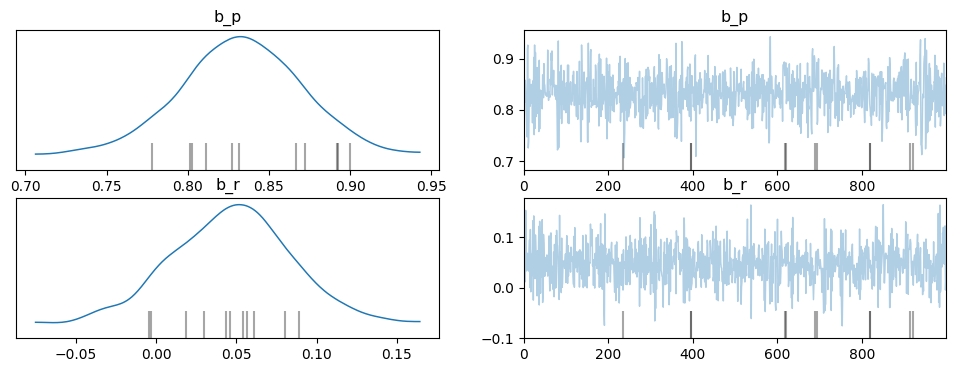

In [12]:
az.plot_trace(trace, var_names=["b_p", "b_r"], compact=False)

### 📈 Análisis de los Intervalos de Credibilidad (94.0% HDI)
- El gráfico presenta los Intervalos de Densidad Más Alta (HDI) al 94% para los coeficientes de las categorías (a_cat[0] a [5]). Este tipo de visualización permite comparar cómo afecta cada categoría a la variable dependiente (probablemente el logaritmo de los ingresos, basado en tu código anterior).

- Puntos clave de la interpretación:
Puntos Blancos: Representan la media (o mediana) posterior de cada categoría. Es el valor más probable para ese parámetro.

- Líneas Gruesas y Delgadas: Indican la incertidumbre. La línea más gruesa suele representar el 50% de la probabilidad, mientras que la delgada abarca el 94% (HDI).

- Comparación de Categorías:

- Categoría [3]: Es la que presenta el valor más alto (cercano a 6.15), sugiriendo un impacto positivo mayor en comparación con las demás.

- Categoría [1]: Es la que tiene el valor más bajo (aproximadamente 5.95) y muestra una mayor dispersión (incertidumbre) hacia la izquierda.

- Categorías [4] y [5]: Tienen comportamientos casi idénticos, con medias situadas alrededor de 6.05.

**Conclusión para el Modelo:**
- Dado que ninguno de los intervalos se solapa con el cero (todos están entre 5.8 y 6.3), se puede confirmar que todas las categorías tienen un efecto estadísticamente significativo y positivo sobre la variable respuesta. Las diferencias entre las categorías [1] y [3] son las más notables, lo que indica que el tipo de producto sí influye considerablemente en el resultado final. 


 
📈 Análisis de Resultados del Modelo Bayesiano  2 Gráfico
El análisis se divide en el efecto de las categorías (interceptos) y el impacto de las variables predictoras (pendientes).

1. Coeficientes por Categoría (a_cat)
El Forest Plot muestra los intervalos de credibilidad al 94% (HDI) para cada categoría de producto.

Impacto Positivo General: Todas las categorías tienen una media posterior entre 5.9 y 6.2. Dado que ningún intervalo cruza el cero, todas tienen un efecto positivo significativo en la variable objetivo (total_revenue_log).

Diferenciación: * La Categoría [3] presenta el desempeño más alto y consistente, con una media cercana a 6.13.

La Categoría [1] es la que muestra menor promedio y mayor incertidumbre (el intervalo es más ancho), lo que sugiere mayor variabilidad en esos productos.

Las categorías [0], [2], [4] y [5] muestran una notable similitud entre sí, con medias que rondan el 6.05.

2. Variables Predictoras: Precio (b_p) y Rating (b_r)
Las gráficas de densidad representan el peso (coeficiente) de las variables estandarizadas en el modelo.

Variable Precio (b_p)
Media = 0.83: Existe una relación fuertemente positiva entre el precio y el ingreso logarítmico. Por cada desviación estándar que aumenta el precio, el ingreso aumenta significativamente.

Significancia: El intervalo HDI (0.76 a 0.91) está totalmente alejado del cero, lo que indica una certeza casi absoluta de que el precio es un predictor clave en este modelo.

Variable Rating (b_r)
Media = 0.047: El impacto de las reseñas es positivo pero mucho más débil en comparación con el precio.

Incertidumbre: El intervalo HDI va de -0.03 a 0.12. Al incluir el valor 0, el modelo nos dice que existe una posibilidad de que el rating no tenga un efecto real o que este sea muy pequeño en el volumen total de ingresos.

**💡 Conclusiones del Análisis**
El Precio domina el modelo: Es el factor con mayor influencia sobre el ingreso total.

El Rating es secundario: Su influencia es marginal y estadísticamente incierta según el intervalo de credibilidad actual.

Diferencias categóricas: El modelo captura con éxito que no todas las categorías generan ingresos de la misma manera, siendo la categoría [3] la más destacada.